In [1]:
'''
Notebook to create results from supporting information in the article

'''

from matplotlib import pyplot as plt
import pickle
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor
import shap
import sys
from matplotlib import pyplot as plt
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold,GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import pickle
import os
import random
import sys
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse, make_scorer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from itertools import repeat, chain
import seaborn as sns

sys.path.append('../src/insulin_pk/utils/') 
from utils import *
!jupyter nbconvert --to script "06B-Supporting_information.ipynb"

[NbConvertApp] Converting notebook 06B-Supporting_information.ipynb to script
[NbConvertApp] Writing 22432 bytes to 06B-Supporting_information.py


In [2]:
## Load data from output of "get_data.ipynb"
Full_data = pd.read_csv("../data/processed/full_data_set.csv")
Full_data.set_index("nncno",inplace=True)
PK_names = ["CL[ml/min/kg]","T1/2[h]","MRT[h]"]
X = Full_data.drop(PK_names,axis=1)

# Correlation plots DS1234

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


<Figure size 2000x1700 with 0 Axes>

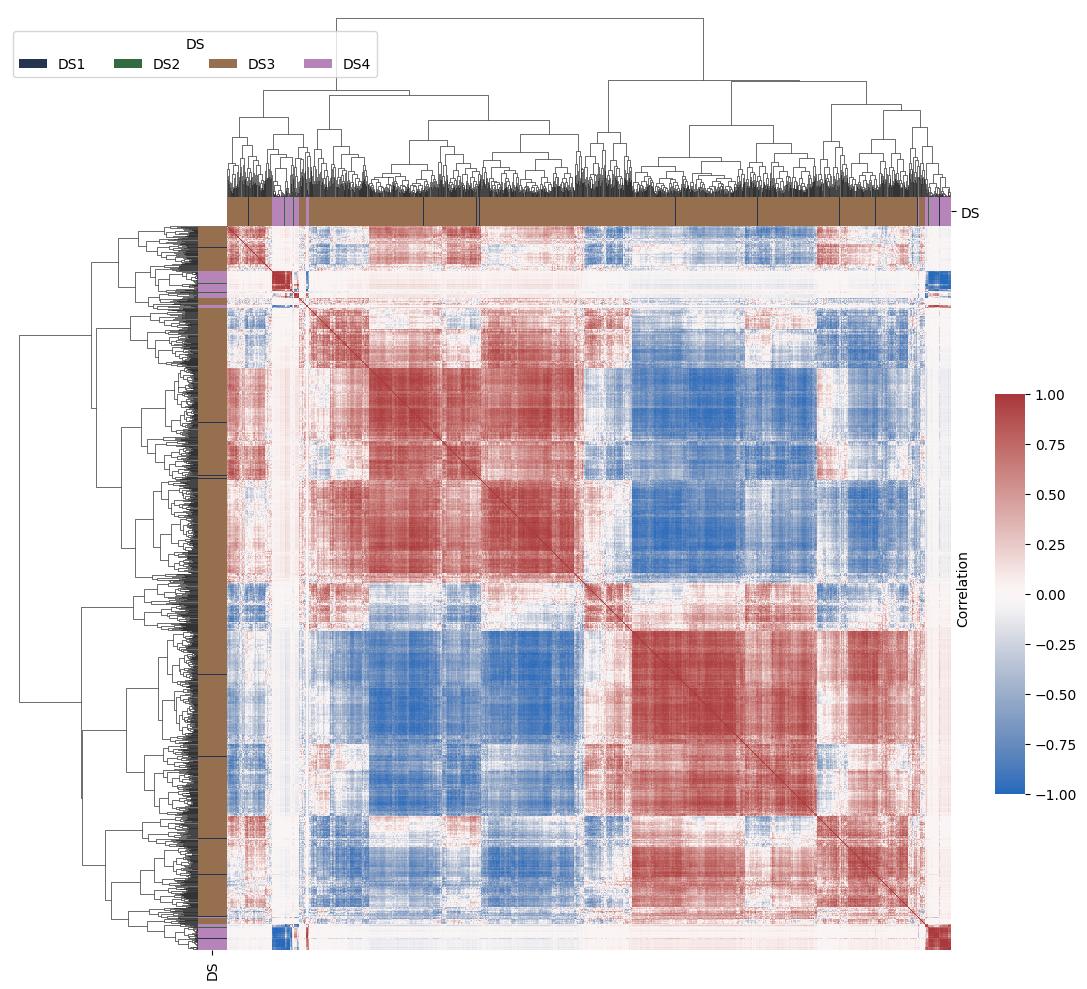

In [3]:
X_corr1 = X.corr()
pd.set_option('display.max_rows', 200)
X_corr1["DS"] = np.where(X_corr1.columns.str.startswith("DS1"), 'DS1', np.where(X_corr1.columns.str.startswith("DS2"),"DS2",np.where(X_corr1.columns.str.startswith("DS3"),"DS3","DS4")))
# Sort both rows and columns:
X_corr1 = X_corr1.sort_values(by = 'DS')

X_corr1.set_index("DS",inplace=True, append=True)
X_corr1.index.rename(["Correlation","DS"],inplace = True)
X_corr1 = X_corr1.reindex(X_corr1.index.get_level_values("Correlation").tolist(), axis=1)

network_labels1 = X_corr1.index.get_level_values("DS")
network_pal1 = sns.cubehelix_palette(network_labels1.unique().size, light=.6, dark=.2, reverse=True, start=1, rot=-2)
network_lut1 = dict(zip(map(str, network_labels1.unique()), network_pal1))
network_colors1 = pd.Series(network_labels1, index=X_corr1.columns).map(network_lut1)
X_corr1 = X_corr1.droplevel(level=1)
plt.figure(figsize=(20,17))
g = sns.clustermap(X_corr1,
# Turn off the clustering
row_cluster=True, col_cluster=True,
#row_cluster=False, col_cluster=False,
# Add colored class labels using data frame created from node and network colors
col_colors = network_colors1,
row_colors = network_colors1,

# Make the plot look better when many rows/cols
linewidths=0,
xticklabels=False, yticklabels=False,
center=0, cmap="vlag",cbar_pos=(1, .2, .03, .4),colors_ratio=0.03,dendrogram_ratio=0.2,vmin=-1, vmax=1,method ="complete")
from matplotlib.pyplot import gcf

for label in network_labels1.unique():
    g.ax_col_dendrogram.bar(0, 0, color=network_lut1[label], label=label, linewidth=0)

l1 = g.ax_col_dendrogram.legend(title='DS', loc="center",ncol=4, bbox_to_anchor=(0.2, 0.94), bbox_transform=gcf().transFigure)
plt.savefig("../reports/figures/Figure_S2.png",bbox_inches = 'tight')
plt.show()

# Correlation plot DS12

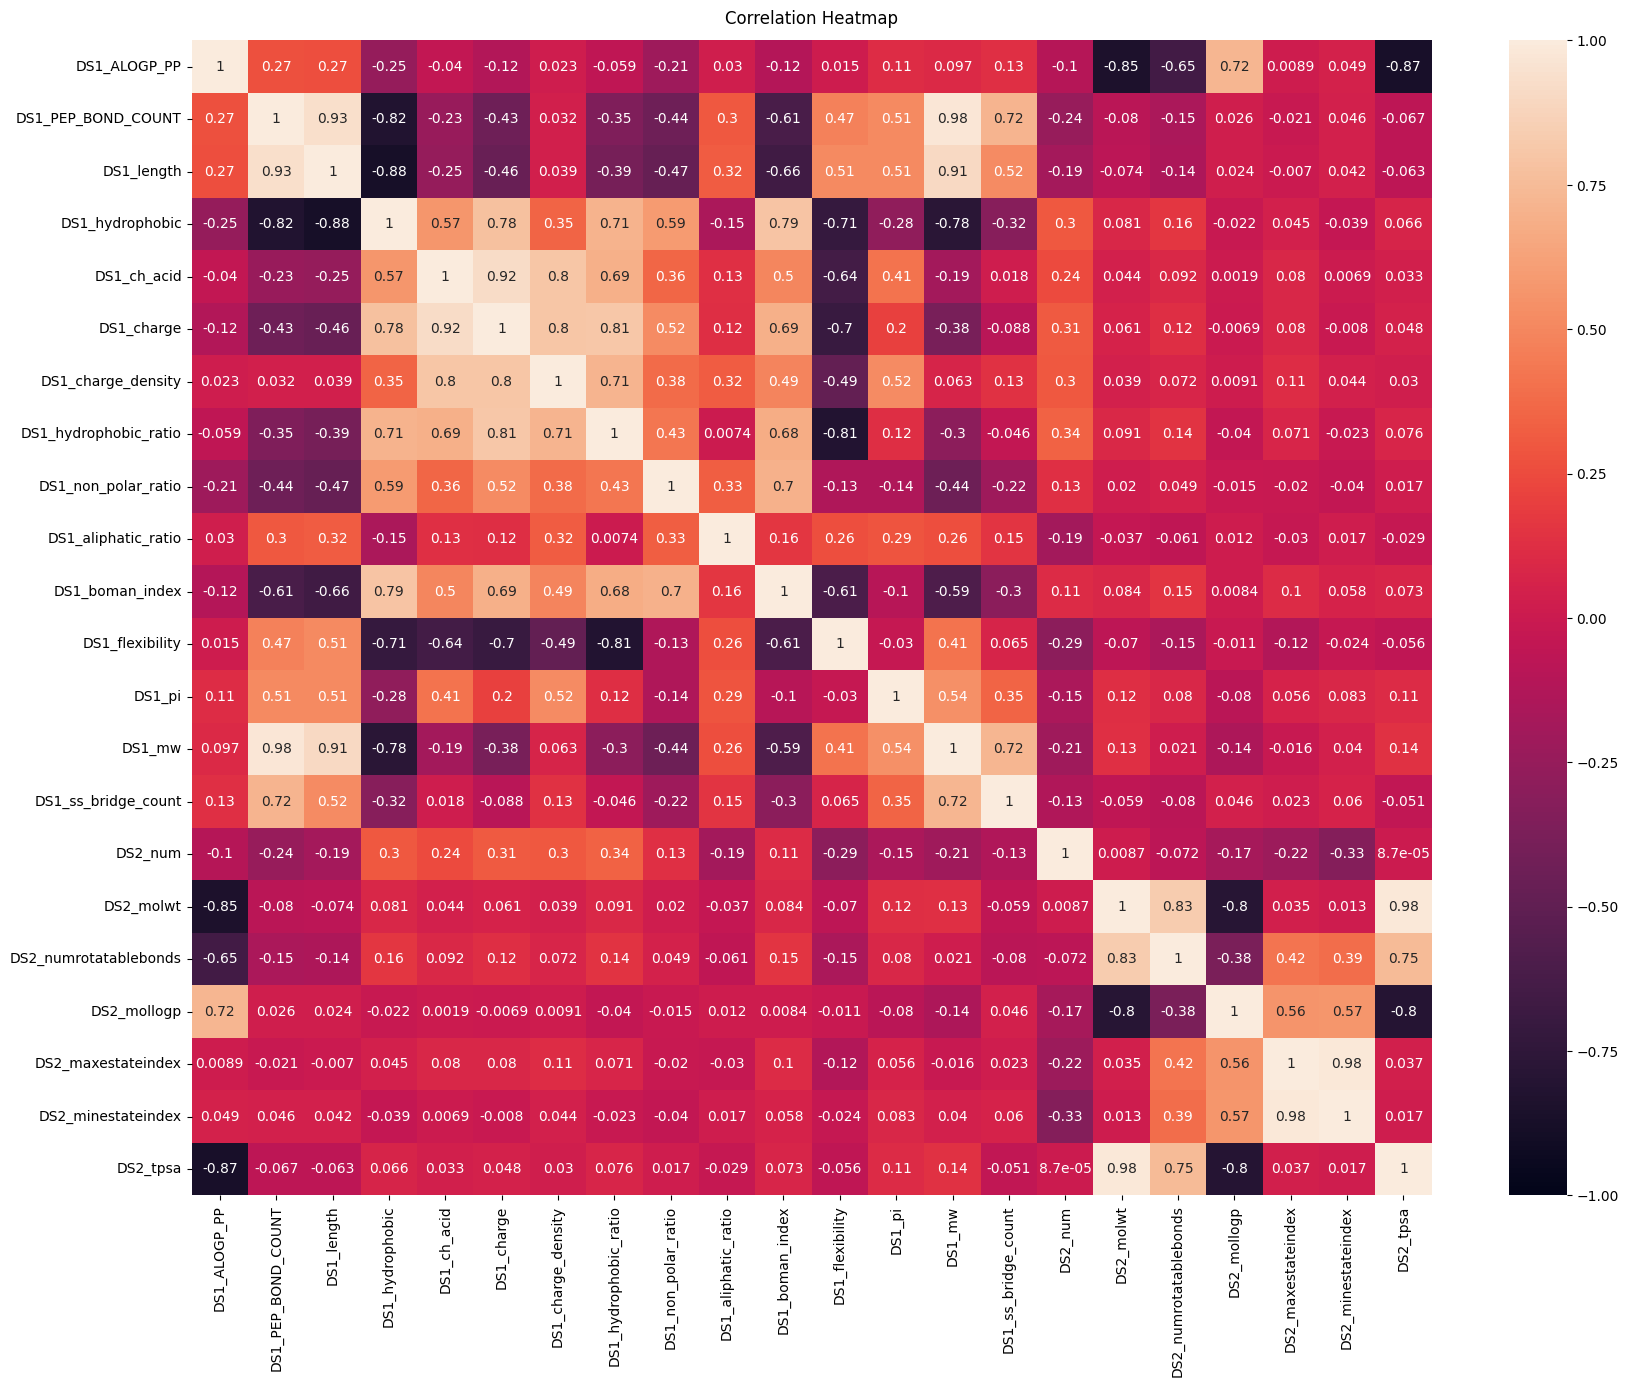

In [4]:
# With groups:
X_DS12 = X.loc[:, X.columns.str.startswith("DS1") | X.columns.str.startswith("DS2")]  
X_corr12 = X_DS12.corr()
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(X_corr12, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig("../reports/figures/Figure_S3.png",bbox_inches = 'tight')

# SHAP value plots

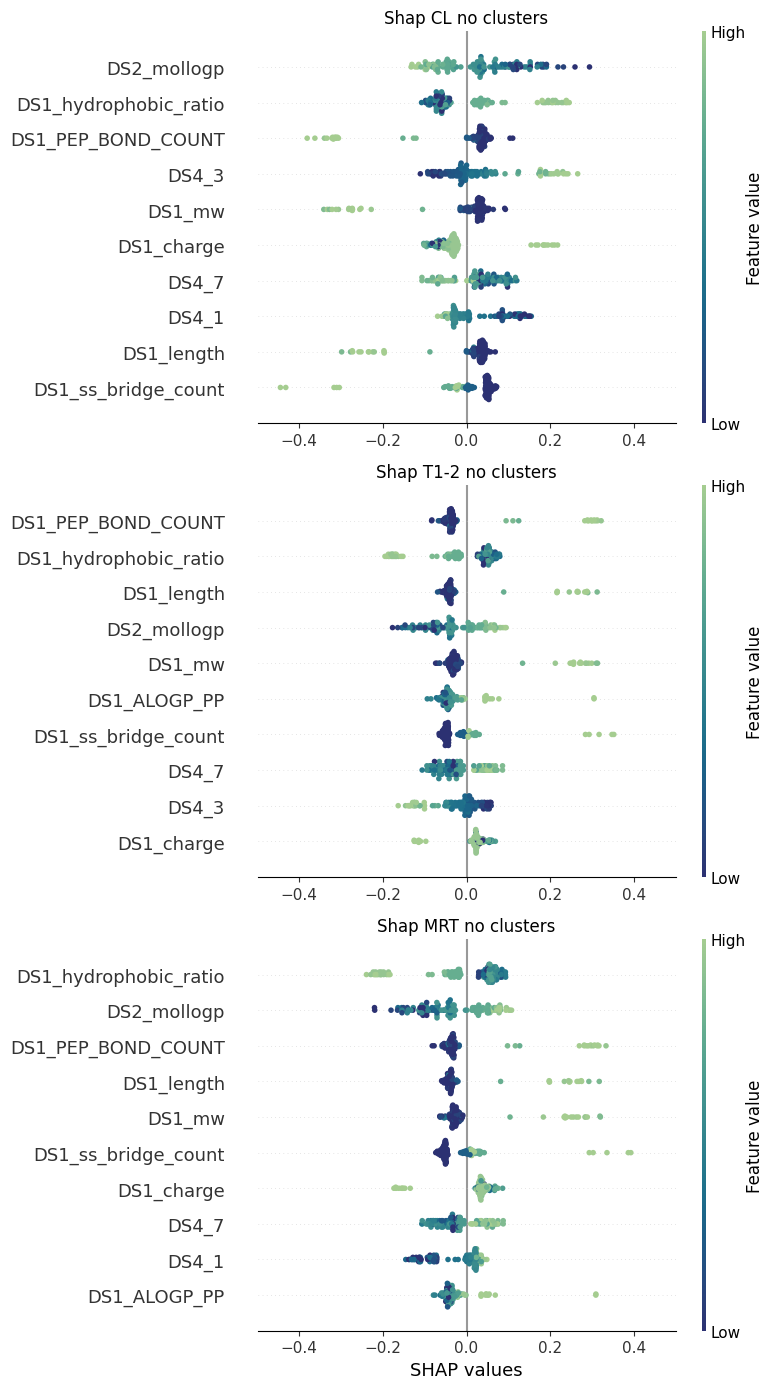

In [5]:
'''
Plot Random Forest SHAP - no groups.

'''
shap_values_RF = pickle.load(open('../data/processed/Random_forest_SHAP_values.pkl','rb'))
X_test_shap_RF = pickle.load(open('../data/processed/Random_forest_SHAP_values_X_test.pkl','rb'))
Y_train_shap_RF = pickle.load(open('../data/processed/Random_forest_SHAP_values_Y_train.pkl','rb'))

fig = plt.figure(figsize=(8, 12))
columns = 1
rows = 3
what_PK = 2
names = ["CL","T1-2","MRT"]
for i in range(1, 4):
    fig.add_subplot(rows, columns, i)
    newcmp = sns.color_palette("crest_r", as_cmap=True)
    shap.summary_plot(shap_values_RF[i-1], X_test_shap_RF,feature_names = X_test_shap_RF.columns,class_names =Y_train_shap_RF.columns ,max_display = 10,show=False,cmap=newcmp,plot_size = (8,14))
    plt.gcf().axes[-1].set_aspect(100)
    plt.gcf().axes[-1].set_box_aspect(100)
    plt.figsize=(18, 6)
    plt.gca().set_xlim(-0.5, 0.5)
    plt.title("Shap {0} no clusters".format(names[i-1]))
    plt.gca().set_xlabel('')
    if i % 3 == 0:
            #plt.xlabel('xlabel', fontsize=label_size)
           # plt.gca().tick_params(axis='both', which='major', labelsize=label_size)
            plt.gca().set_xlabel('SHAP values')
    
#plt.show() 
#plt.savefig("/home/kyei/Project1/Figures/RF_DS124_shap_total_no_clusters.png",bbox_inches = 'tight')

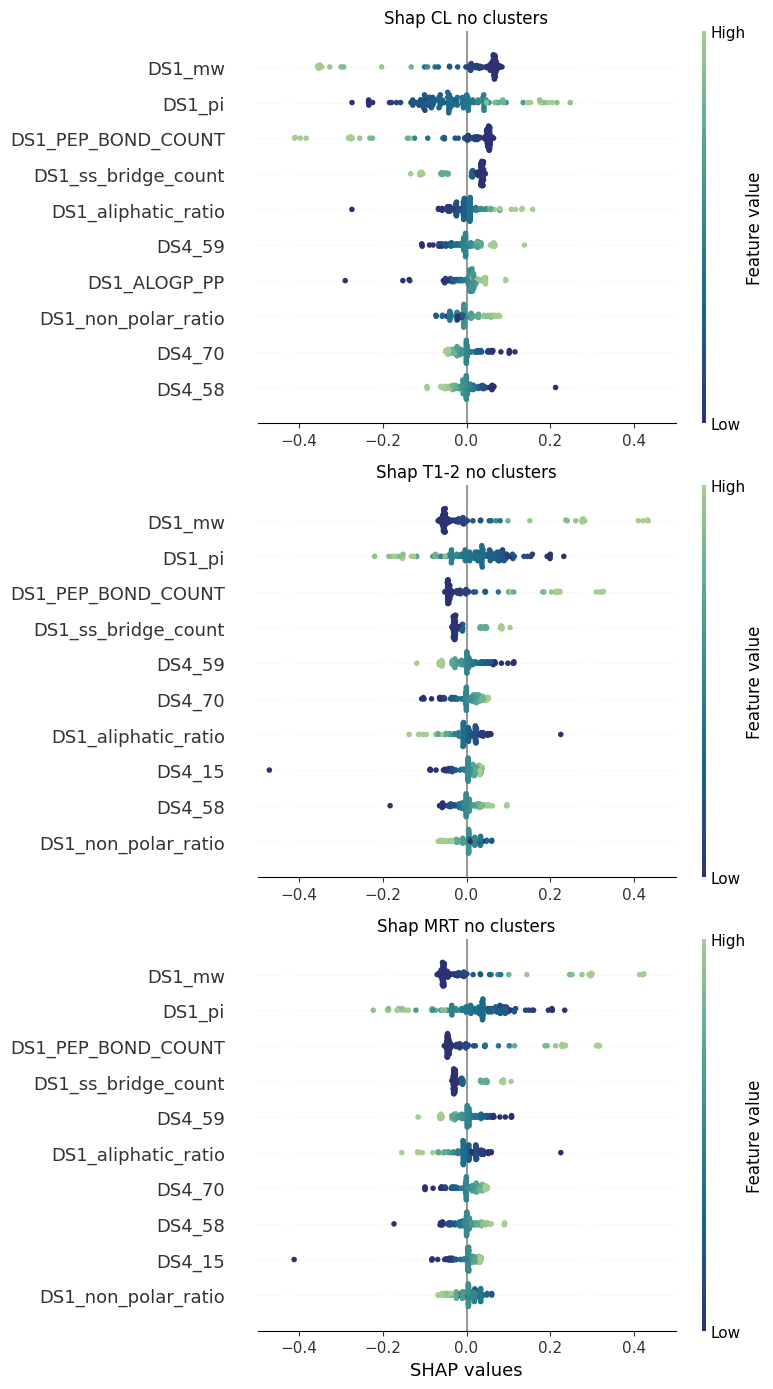

In [6]:
'''
Plot ANN SHAP - no groups.

'''
shap_values_ANN = pickle.load(open('../data/processed/ANN_SHAP_values.pkl','rb'))
X_test_shap_ANN = pickle.load(open('../data/processed/ANN_SHAP_values_X_test.pkl','rb'))
Y_train_shap_ANN = pickle.load(open('../data/processed/ANN_SHAP_values_Y_train.pkl','rb'))

fig = plt.figure(figsize=(8, 12))
columns = 1
rows = 3
what_PK = 2
names = ["CL","T1-2","MRT"]
for i in range(1, 4):
    fig.add_subplot(rows, columns, i)
    newcmp = sns.color_palette("crest_r", as_cmap=True)
    shap.summary_plot(shap_values_ANN[i-1], X_test_shap_ANN,feature_names = X_test_shap_ANN.columns,class_names =Y_train_shap_ANN.columns ,max_display = 10,show=False,cmap=newcmp,plot_size = (8,14))
    plt.gcf().axes[-1].set_aspect(100)
    plt.gcf().axes[-1].set_box_aspect(100)
    plt.figsize=(18, 6)
    plt.gca().set_xlim(-0.5, 0.5)
    plt.title("Shap {0} no clusters".format(names[i-1]))
    plt.gca().set_xlabel('')
    if i % 3 == 0:
            #plt.xlabel('xlabel', fontsize=label_size)
           # plt.gca().tick_params(axis='both', which='major', labelsize=label_size)
            plt.gca().set_xlabel('SHAP values')
    
#plt.show() 
#plt.savefig("/home/kyei/Project1/Figures/RF_DS124_shap_total_no_clusters.png",bbox_inches = 'tight')

# Compare individual group training with global model

In [3]:
def store_ANN_data_grouped():
    '''
    Function to load ANN output data and store all in dictionary
    output:
        - store_dict: Dictionary with Descriptorset x fold x output info
        - outer_rmse_dict: Extracted the outer test scores for each descriptorset for each fold
        
    '''
    
    Descriptor_combinations = ["DS1","DS12","DS123","DS1234","DS124","DS134","DS14","DS13","DS2","DS3","DS4","DS23","DS24","DS234","DS34"]
    
    store_dict = {}
    outer_rmse_dict = {}
    for i in Descriptor_combinations:
        outer_rmse_list = []
        data = pickle.load(open('../data/processed/ANN_outer_5_test_grouped_{}.pkl'.format(i),'rb'))
        store_dict[i] = data
        for j in range(len(store_dict["DS1"])):
            outer_rmse_list.append(store_dict[i][j]["best_rmse"])
        outer_rmse_dict[i] = outer_rmse_list
    return store_dict, outer_rmse_dict

def store_ANN_data():
    '''
    Function to load ANN output data and store all in dictionary
    output:
        - store_dict: Dictionary with Descriptorset x fold x output info
        - outer_rmse_dict: Extracted the outer test scores for each descriptorset for each fold
        
    '''
    
    Descriptor_combinations = ["DS1","DS12","DS123","DS1234","DS124","DS134","DS14","DS13","DS2","DS3","DS4","DS23","DS24","DS234","DS34"]
    
    store_dict = {}
    outer_rmse_dict = {}
    for i in Descriptor_combinations:
        outer_rmse_list = []
        data = pickle.load(open('../data/processed/ANN_outer_5_test_{}.pkl'.format(i),'rb'))
        store_dict[i] = data
        for j in range(len(store_dict["DS1"])):
            outer_rmse_list.append(store_dict[i][j]["best_rmse"])
        outer_rmse_dict[i] = outer_rmse_list
    return store_dict, outer_rmse_dict

def extract_ANN_data_for_plot(ANN_total_data,DS):
    '''
    Function to extract predictions and observations from ANN results.
    Output: Pd dataframe with columns: [nncno, Type (pred/obs), variable (PK), value, Fold]
    
    '''

    scatter_long_pd = pd.DataFrame()
    for i in range(5):

        y_pred = ANN_total_data[DS][i]["output_tensor"].assign(Type = "predictions")
        y_target = ANN_total_data[DS][i]["True_Y"].assign(Type = "observations")
        scatter_long_tmp = pd.concat([y_pred,y_target],axis=0).reset_index().melt(id_vars = ["nncno","Type"]).assign(Fold = i)
        scatter_long_pd = pd.concat([scatter_long_pd,scatter_long_tmp],axis=0)
    return scatter_long_pd

def extract_ANN_data_for_plot_no_DS(ANN_total_data):
    '''
    Function to extract predictions and observations from ANN results for single runs of ANN model (no Descriptor space saved)
    Output: Pd dataframe with columns: [nncno, Type (pred/obs), variable (PK), value, Fold]
    
    '''

    scatter_long_pd = pd.DataFrame()
    for i in range(5):

        y_pred = ANN_total_data[i]["output_tensor"].assign(Type = "predictions")
        y_target = ANN_total_data[i]["True_Y"].assign(Type = "observations")
        scatter_long_tmp = pd.concat([y_pred,y_target],axis=0).reset_index().melt(id_vars = ["nncno","Type"]).assign(Fold = i)
        scatter_long_pd = pd.concat([scatter_long_pd,scatter_long_tmp],axis=0)
    return scatter_long_pd


def r2_rmse(g):
    '''
    Function to calculate root-mean-square-error (RMSE) between two columns "observations" and "predictions"
    
    '''
    r2 = r2_score( g['observations'], g['predictions'] )
    rmse = np.sqrt( mean_squared_error( g['observations'], g['predictions'] ) )
    return pd.Series(dict(rmse = rmse))



In [13]:
groups = ['Other', 'Acylation', 'No attachments', 'Concatenated proteins', 'Antibody attachment (Fc)', 'AA extensions']
#groups = ['Other', 'Acylation', 'No attachments']


In [14]:
ANN_DS1234_groups_data = {}
for i in range(len(groups)):
    data = pickle.load(open('../data/processed/ANN_outer_5_test_DS1234_{}.pkl'.format(groups[i]),'rb'))
    ANN_DS1234_groups_data[groups[i]] = extract_ANN_data_for_plot_no_DS(data)


In [15]:
#for i in groups:
#    if i == "Other":
#        print( "========== ANN local model =============")
#   print("====  {} =====".format(i))
#    print(ANN_DS1234_groups_data[i].pivot(index = ["nncno","variable","Fold"],columns = "Type",values = "value").reset_index().set_index("nncno").groupby("variable").apply( r2_rmse ))

========== ANN local model =============
====  Other =====
                   rmse
variable               
CL[ml/min/kg]  1.256833
MRT[h]         0.920621
T1/2[h]        0.962969
====  Acylation =====
                   rmse
variable               
CL[ml/min/kg]  0.499119
MRT[h]         0.461694
T1/2[h]        0.458277
====  No attachments =====
                   rmse
variable               
CL[ml/min/kg]  0.738328
MRT[h]         0.759136
T1/2[h]        0.753797
====  Concatenated proteins =====
                   rmse
variable               
CL[ml/min/kg]  0.578797
MRT[h]         0.349140
T1/2[h]        0.329324
====  Antibody attachment (Fc) =====
                   rmse
variable               
CL[ml/min/kg]  0.576145
MRT[h]         0.594736
T1/2[h]        0.443750
====  AA extensions =====
                       rmse
variable                   
CL[ml/min/kg]  3.280672e+11
MRT[h]         1.224281e+13
T1/2[h]        1.196911e+13


In [8]:
ANN_total_data_grouped, ANN_rmse_data_grouped = store_ANN_data_grouped()
ANN_total_data, ANN_rmse_data = store_ANN_data()

In [9]:
RF_DS124_test_groups = pickle.load(open('/home/kyei/Project1_clean/data/Random_forest_outer_test_scorer_DS124_groups.pkl','rb'))
RF_DS124_scatter_groups = pickle.load(open('/home/kyei/Project1_clean/data/Random_forest_scatter_file_DS124_groups.pkl','rb'))
RF_DS124_hyp_groups = pickle.load(open('/home/kyei/Project1_clean/data/Random_forest_hyperparameter_file_DS124_groups.pkl','rb'))

RF_DS124_test = pickle.load(open('/home/kyei/Project1_clean/data/Random_forest_outer_test_scorer.pkl','rb'))
RF_DS124_scatter= pickle.load(open('/home/kyei/Project1_clean/data/Random_forest_scatter_file.pkl','rb'))
RF_DS124_hyp = pickle.load(open('/home/kyei/Project1_clean/data/Random_forest_hyperparameter_file.pkl','rb'))


In [41]:

for i in groups:
    if i == "Other":
        print( "========== Random Forest local model =============")
    print("====  {} =====".format(i))
    print(RF_DS124_scatter_groups[i].pivot(index = ["nncno","variable","Fold"],columns = "Type",values = "value").reset_index().set_index("nncno").groupby("variable").apply( r2_rmse ))

========== Random Forest local model =============
====  Other =====
                   rmse
variable               
CL[ml/min/kg]  1.379902
MRT[h]         0.899444
T1/2[h]        0.883250
====  Acylation =====
                   rmse
variable               
CL[ml/min/kg]  0.506274
MRT[h]         0.477599
T1/2[h]        0.455938
====  No attachments =====
                   rmse
variable               
CL[ml/min/kg]  0.695275
MRT[h]         0.625551
T1/2[h]        0.628843
====  Concatenated proteins =====
                   rmse
variable               
CL[ml/min/kg]  0.522815
MRT[h]         0.340027
T1/2[h]        0.321393
====  Antibody attachment (Fc) =====
                   rmse
variable               
CL[ml/min/kg]  0.503012
MRT[h]         0.501097
T1/2[h]        0.365622
====  AA extensions =====
                   rmse
variable               
CL[ml/min/kg]  0.504216
MRT[h]         0.523685
T1/2[h]        0.652556


In [11]:
Data_with_groups = pd.read_excel("~/Project1_clean/data/raw/Data_with_groups.xlsx")
Data_with_groups.rename(columns={"NNCNo": "nncno"})
Data_with_groups.set_index("NNCNo",inplace=True)
Data_with_groups = Data_with_groups[~Data_with_groups.index.isin(["0148-0000-1247"])]

data_wg = pd.merge(Full_data, Data_with_groups["Groups"], left_index=True, right_index=True)
data_wg.index.name = "nncno"

In [42]:
## Make ANN data:
global_model_DS1234 = extract_ANN_data_for_plot(ANN_total_data,"DS1234")
dict_converter = data_wg.reset_index()[["nncno","Groups"]].set_index("nncno").to_dict()["Groups"]
global_model_DS1234["Groups"] = global_model_DS1234["nncno"].map(dict_converter)

groups = ['Other', 'Acylation', 'No attachments', 'Concatenated proteins', 'Antibody attachment (Fc)', 'AA extensions']
for i in groups:
    if i == "Other":
        print("==================== ANN global model ======================")
    print("====  {} =====".format(i))
    print(global_model_DS1234[global_model_DS1234.Groups == i].pivot(index = ["nncno","variable","Fold"],columns = "Type",values = "value").reset_index().set_index("nncno").groupby("variable").apply( r2_rmse ))

==================== ANN global model ======================
====  Other =====
                   rmse
variable               
CL[ml/min/kg]  1.250862
MRT[h]         0.889738
T1/2[h]        0.833635
====  Acylation =====
                   rmse
variable               
CL[ml/min/kg]  0.562350
MRT[h]         0.494190
T1/2[h]        0.500329
====  No attachments =====
                   rmse
variable               
CL[ml/min/kg]  1.901990
MRT[h]         1.293640
T1/2[h]        1.127599
====  Concatenated proteins =====
                   rmse
variable               
CL[ml/min/kg]  0.631686
MRT[h]         0.442614
T1/2[h]        0.413805
====  Antibody attachment (Fc) =====
                   rmse
variable               
CL[ml/min/kg]  0.455932
MRT[h]         0.485615
T1/2[h]        0.437023
====  AA extensions =====
                   rmse
variable               
CL[ml/min/kg]  0.620315
MRT[h]         0.624387
T1/2[h]        0.735414


In [43]:
global_model_DS124 = RF_DS124_scatter["DS124"]
dict_converter = data_wg.reset_index()[["nncno","Groups"]].set_index("nncno").to_dict()["Groups"]
global_model_DS124["Groups"] = global_model_DS124["nncno"].map(dict_converter)
for i in groups:
    if i == "Other":
        print("==================== Random Forest global model ======================")
    print("====  {} =====".format(i))
    print(global_model_DS124[global_model_DS124.Groups == i].pivot(index = ["nncno","variable","Fold"],columns = "Type",values = "value").reset_index().set_index("nncno").groupby("variable").apply( r2_rmse ))

==================== Random Forest global model ======================
====  Other =====
                   rmse
variable               
CL[ml/min/kg]  1.169328
MRT[h]         0.775866
T1/2[h]        0.744966
====  Acylation =====
                   rmse
variable               
CL[ml/min/kg]  0.494444
MRT[h]         0.449141
T1/2[h]        0.457892
====  No attachments =====
                   rmse
variable               
CL[ml/min/kg]  1.620273
MRT[h]         1.319532
T1/2[h]        1.175844
====  Concatenated proteins =====
                   rmse
variable               
CL[ml/min/kg]  0.620248
MRT[h]         0.420041
T1/2[h]        0.382104
====  Antibody attachment (Fc) =====
                   rmse
variable               
CL[ml/min/kg]  0.495557
MRT[h]         0.496381
T1/2[h]        0.396205
====  AA extensions =====
                   rmse
variable               
CL[ml/min/kg]  0.552934
MRT[h]         0.510356
T1/2[h]        0.687587


# Results on molecular weight in each group

In [39]:
print(data_wg.groupby("Groups")["DS1_mw"].mean("DS1_mw"))

Groups
AA extensions               26486.126031
Acylation                    6331.213129
Antibody attachment (Fc)    59472.568113
Concatenated proteins       16314.609761
No attachments               5709.681178
Other                       12215.799984
Name: DS1_mw, dtype: float64


# plot figure 3 but with leave project out

In [ ]:
# RF data
plt.style.use('ggplot')
sns.set(font_scale=2)
Random_forest_outer_test_scores = pickle.load(open('/home/kyei/Project1_clean/data/Random_forest_outer_test_scorer_groupedsplit.pkl','rb'))

Random_forest_outer_test_scores_pd = pd.DataFrame(Random_forest_outer_test_scores)

Random_forest_outer_test_scores_long = Random_forest_outer_test_scores_pd.melt()
Random_forest_outer_test_scores_long["Model"] = "Random Forest"
# ANN data
ANN_outer_test_scores_pd = pd.DataFrame(ANN_rmse_data_grouped)
ANN_outer_test_scores_long = ANN_outer_test_scores_pd.melt()
ANN_outer_test_scores_long["Model"] = "ANN"

# Total data concatenated for plotting
outer_test_data = pd.concat([Random_forest_outer_test_scores_long,ANN_outer_test_scores_long],axis=0)

## PLotting
g = sns.catplot(x="variable", y="value", data=outer_test_data, kind="box",col = "Model",order=sorted(outer_test_data.variable.unique()),palette=sns.color_palette("muted"),height=8,aspect=1.4,)
g.map(sns.swarmplot, 'variable', 'value', color='k', order=sorted(outer_test_data.variable.unique()))
g.set(xlabel='Descriptor Space (DS)', ylabel='RMSE',title = "",yticks = np.arange(0.45,3,0.2))
g.set(ylim=(0.4, 3))
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
left1, bottom1, width1, height1 = (-16, 0.5, 8, 0.18)

g.savefig('/home/kyei/Project1_clean/reports/figures/Figure3_top_groupedsplit.png', bbox_inches='tight') 

In [ ]:
## Zoomed in area (black box)
Random_forest_outer_test_scores_reduced = Random_forest_outer_test_scores_pd.loc[:, Random_forest_outer_test_scores_pd.columns.str.contains('1')]
Random_forest_outer_test_scores_long = Random_forest_outer_test_scores_reduced.melt()
g = sns.catplot(x="variable", y="value", data=Random_forest_outer_test_scores_long, kind="box",order=sorted(Random_forest_outer_test_scores_long.variable.unique()),palette=sns.color_palette("muted"),height=8,aspect=1.4)
g.map(sns.swarmplot, 'variable', 'value', color='k', order=sorted(Random_forest_outer_test_scores_long.variable.unique()))
g.set(xlabel='Descriptor Space (DS)', ylabel='RMSE',title = "",yticks = np.arange(0.45,1.85,0.1))
g.set(ylim=(0.45, 1.85))
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
g.savefig('/home/kyei/Project1_clean/reports/figures/Figure3_bottom_RF_groupedsplit.png', bbox_inches='tight') 

In [ ]:
## Zoomed in area (black box)
ANN_outer_test_scores_reduced = ANN_outer_test_scores_pd.loc[:, ANN_outer_test_scores_pd.columns.str.contains('1')]
ANN_outer_test_scores_reduced_long = ANN_outer_test_scores_reduced.melt()
g = sns.catplot(x="variable", y="value", data=ANN_outer_test_scores_reduced_long, kind="box",order=sorted(ANN_outer_test_scores_reduced_long.variable.unique()),palette=sns.color_palette("muted"),height=8,aspect=1.4)
g.map(sns.swarmplot, 'variable', 'value', color='k', order=sorted(ANN_outer_test_scores_reduced_long.variable.unique()))
g.set(xlabel='Descriptor Space (DS)', ylabel='RMSE',title = "",yticks = np.arange(0.45,1.85,0.1))
g.set(ylim=(0.45, 1.85))
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
g.savefig('/home/kyei/Project1_clean/reports/figures/Figure3_bottom_ANN_grouped.png', bbox_inches='tight') 

# Comapre RF, ANN og KNN on DS3 only 

In [34]:
data3 = contruct_descriptor_sets(Full_data,pd.Series("3"),with_PK = True)

In [35]:
# K nearest neighbor.
Group = "nncno"
#Start with results for DS1
## Important! Make sure splits setups are the same as in "Create_data.ipynb" to ensure legitimate comparison.
response = ["CL[ml/min/kg]","T1/2[h]","MRT[h]"]
X_vivo = data3.drop(response,axis=1)
Y_vivo = data3[response]
Y_vivo = np.log(Y_vivo)

KFold_outer = GroupKFold(n_splits=5)
pandas_save_predict = {}
pandas_save_target = {}
param_grid = {
    'KNN__n_neighbors': [1,3,5]}
test_save = []
save_FI = []
for j, (outer_train_idx, test_idx) in enumerate(KFold_outer.split(X_vivo, groups = X_vivo.index.get_level_values(Group))):
    X_train_outer, X_test, Y_train_outer, Y_test = X_vivo.iloc[outer_train_idx], X_vivo.iloc[test_idx], Y_vivo.iloc[outer_train_idx], Y_vivo.iloc[test_idx]
    KFold_inner = GroupShuffleSplit(n_splits=1,test_size = 0.15,random_state=42).split(X_train_outer,groups =X_train_outer.index.get_level_values(Group))    
    KFold_inner_copy = GroupShuffleSplit(n_splits=1,test_size = 0.15,random_state=42).split(X_train_outer,groups =X_train_outer.index.get_level_values(Group))    
    
    ### Moving on
    numeric_features = list(X_train_outer.select_dtypes(include=[np.number]).columns)
    categorical_features = list(X_train_outer.select_dtypes(exclude=[np.number]).columns)
    
    num_pipe = Pipeline([('Scale',StandardScaler())])
    cat_pipe = Pipeline(steps=[('OHE',OneHotEncoder(sparse=False,handle_unknown = "ignore"))])
    
    preprocessor = ColumnTransformer(transformers=[('num_pipe', num_pipe, numeric_features),('cat_pipe', cat_pipe, categorical_features)],remainder='passthrough')
    estimator = Pipeline([('preproc', preprocessor), ('KNN', KNeighborsRegressor(n_neighbors=2))])
    ## Lets do nested cross validation to lower the bias:    
    ### Make inner CV loop with Gridsearch and outer loop with cross_validate.
    GridObject = GridSearchCV(cv = KFold_inner,estimator = estimator, param_grid = param_grid, scoring = make_scorer(mse,greater_is_better=False), n_jobs = -1, verbose = 1,return_train_score=True,refit=True)
    GridObject.fit(X_train_outer,Y_train_outer)
    #print(GridObject.best_params_)
    #print(GridObject.cv_results_['mean_test_score'])
    #save_FI.append(GridObject.best_estimator_.named_steps["RF"].feature_importances_)
    
    ypred = GridObject.predict(X_test)
    test_save.append(np.sqrt(mse(Y_test,ypred)))
    pandas_save_predict[j] = ypred
    pandas_save_target[j] = Y_test


FI = pd.DataFrame(save_FI).T.mean(1)
FI["names"] = X_train_outer.columns
with open('/home/kyei/Project1_clean/models/RF_Vivo_DS3_KNN.pkl','wb') as f:pickle.dump(test_save,f )
print(Y_test.shape)
#estimator.fit(X_vivo,Y_vivo)
#names1 =list(estimator.named_steps['preproc'].transformers_[1][1].named_steps['OHE'].get_feature_names_out(categorical_features))
#names_concat = np.concatenate((numeric_features, names1), axis=None)


Fitting 1 folds for each of 3 candidates, totalling 3 fits
{'KNN__n_neighbors': 5}
Fitting 1 folds for each of 3 candidates, totalling 3 fits
{'KNN__n_neighbors': 5}
Fitting 1 folds for each of 3 candidates, totalling 3 fits
{'KNN__n_neighbors': 5}
Fitting 1 folds for each of 3 candidates, totalling 3 fits
{'KNN__n_neighbors': 5}
Fitting 1 folds for each of 3 candidates, totalling 3 fits
{'KNN__n_neighbors': 5}
(128, 3)


In [36]:
Vivo_RF_DS3 = pickle.load(open('/home/kyei/Project1_clean/data/Random_forest_outer_test_scorer.pkl','rb'))["DS3"]
Vivo_ANN_DS3 = ANN_rmse_data["DS3"]
Vivo_KNN_DS3 = pickle.load(open('/home/kyei/Project1_clean/models/RF_Vivo_DS3_KNN.pkl','rb'))


In [ ]:
# Plot Random forest results:
for_plot = pd.DataFrame(np.transpose([Vivo_ANN_DS3, Vivo_RF_DS3, Vivo_KNN_DS3]))

for_plot.columns = ["ANN","RF","KNN"]
#print(for_plot)
for_plot= for_plot.melt()
for_plot["Model"] = "Random Forest"
sns.set(font_scale=2.2)
# make boxplot with data from the OP
plt.style.use('ggplot')
sns.set(font_scale=2)
g = sns.catplot(x="variable", y="value", col="Model", data=for_plot, kind="box",order=sorted(for_plot.variable.unique()),palette=sns.color_palette("muted"),height=7)
g.map(sns.swarmplot, 'variable', 'value', color='k', order=sorted(for_plot.variable.unique()))
g.set(xlabel='Models (All on DS3) ', ylabel='RMSE',title = "",yticks = np.arange(0.45,1.2,0.1))
g.set(ylim=(0.45, 1.2))
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
g.savefig('/home/kyei/Project1_clean/reports/figures/KNN_Compare.png', bbox_inches='tight') 

# Compare DS3 embeddings 

In [38]:
Vivo_ANN_DS3_ESM = ANN_rmse_data["DS3"]
Vivo_ANN_DS3_OHE = pickle.load(open('/home/kyei/Project1_clean/data/processed/OHE_data.pkl','rb'))
Vivo_ANN_DS3_Zscale = pickle.load(open('/home/kyei/Project1_clean/data/processed/Zscale_data.pkl','rb'))

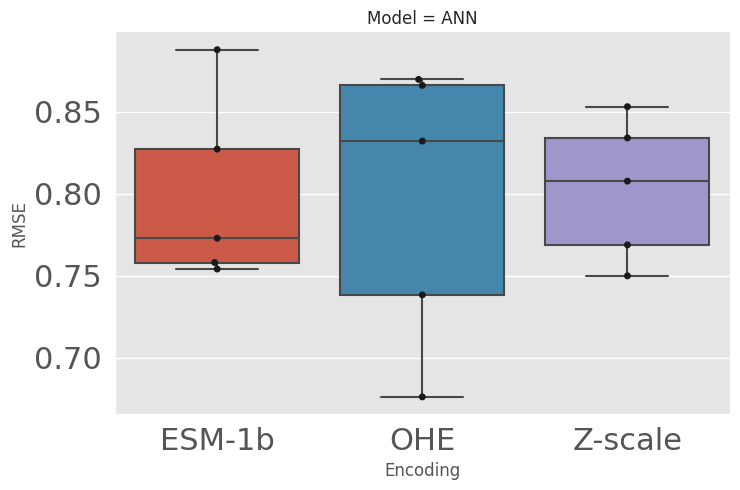

In [39]:
for_plot = pd.DataFrame(np.transpose([Vivo_ANN_DS3_ESM,Vivo_ANN_DS3_OHE,Vivo_ANN_DS3_Zscale]))
for_plot
for_plot.columns = ["ESM-1b","OHE","Z-scale"]
for_plot
for_plot= for_plot.melt()
for_plot["Model"] = "ANN"

# make boxplot with data from the OP
plt.style.use('ggplot')

g = sns.catplot(x="variable", y="value", col="Model", data=for_plot, kind="box",order=sorted(for_plot.variable.unique()), height=5, aspect=1.5)
g.map(sns.swarmplot, 'variable', 'value', color='k', order=sorted(for_plot.variable.unique()))
g.set(xlabel='Encoding', ylabel='RMSE')
g.savefig('/home/kyei/Project1_clean/reports/figures/DS3_compare_encoding.png', bbox_inches='tight',dpi = 800) 


In [40]:
from scipy import stats
print(stats.ttest_rel(Vivo_ANN_DS3_ESM, Vivo_ANN_DS3_OHE)[1])
print(stats.ttest_rel(Vivo_ANN_DS3_ESM, Vivo_ANN_DS3_Zscale)[1])
print(stats.ttest_rel(Vivo_ANN_DS3_OHE, Vivo_ANN_DS3_Zscale)[1])


0.8909260363050742
0.9277369987303559
0.8765303650517182
